In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg
import numpy.polynomial
import pandas as pd
import scipy
import scipy.special
from sympy.ntheory import continued_fraction
import fractions
matplotlib.use('Agg')
%matplotlib inline

In [29]:
def print_matrix(_mat):
    df = pd.DataFrame(_mat)
    print(df.to_string(index=False, header=False))

## Plotting the Kohomoto butterfly

For some introduction
The Kohomoto butterfly is a plot of the spectrum of the discrete schrodinger operator on a quasiperiodic chain.

If we look at a function $f:\mathbb{Z}\to\mathbb{R}$ we can define for a given $\alpha \in (0,1)$ the operator
$H_\alpha$ which operates on the function $f$ and returns a function of the same kind
(which we will mark as $H_\alpha f$) like so:
$$[H_\alpha f](n) = f(n-1)+f(n+1)+V(n)f(n)$$
Where $V(n)$ is a function from the integers to the real numbers which is named the potential.
This potential is the quasiperiodic chain.

Now for a given $\alpha$ and a given $v$
$$V(n)=   \begin{cases}  v, \quad \text{  if   } \,\, 1-\alpha\leq z(n) < 1 \\ 0,  \quad \text{otherwise} \end{cases}$$
This $H_\alpha$ operator can be thought about as an infinite matrix where the diagonal is $V(n)$ and the superdiagonal
and subdiagonal are 1.
$$H_\alpha =
\begin{pmatrix}
\ddots& &  &  &  &  &\\
&V(-2) & 1 & 0 & 0 & 0&\\
&1 & V(-1) & 1 & 0 & 0&\\
&0 & 1 & V(0) & 1 & 0 &\\
&0 & 0 & 1 & V(1) & 1 &\\
&0 & 0 & 0 & 1 & V(2) &\\
& &  &  &  &  & \ddots
\end{pmatrix}$$
The spectrum of $H_\alpha$ can be thought of as its eigenvalues, the Kohomoto butterfly is a plot of $\alpha$ against
$H_\alpha$ spectrum.

We know how to draw the spectrum for a rational $\alpha$ and so that is what we will draw.
We will explore 2 ways to draw the butterfly.

* Using submatrices of $H_\alpha$
* With the Bloch theorem

### Plotting the butterfly with submatrices of $H_\alpha$

Let $\frac{p}{q}$ be the lowest term of the rational $\alpha$ then we know that $V(n)$ is periodic with a cycle of size q.
We will look at a submatrix of size $q\times q$ of $H_\alpha$.
We'll name the submatrix as $H_q$

In [30]:
def get_matrix_for_alpha(p, q, v=1):
    alpha = fractions.Fraction(p,q)
    p = alpha.numerator
    q = alpha.denominator
    _mat = np.zeros((q,q), dtype=np.int32)
    _mat[np.arange(0, q-1), np.arange(1, q)] = 1
    _mat[np.arange(1, q), np.arange(0, q-1)] = 1
    for i in range(q):
        na = np.multiply(alpha,i)
        na = na - np.floor(na)
        _mat[i][i] = v if na >= 1 - alpha else 0
    return _mat

Now we will parametrize $H_q$ with $\theta$ so for example for $q=5$ with some $V(n)$

$$H_q(\theta) =
\begin{pmatrix}
v & 1 & 0 & 0 & e^{-i\theta}\\
1 & v & 1 & 0 & 0\\
0 & 1 & 0 & 1 & 0\\
0 & 0 & 1 & 0 & 1\\
e^{i\theta} & 0 & 0 & 1 & v\\
\end{pmatrix}$$

now for each $\theta$ we can get the eigenvalues of $H_q(\theta)$ and plot them against $\theta$
We should get $q$ separate plot lines.

Each plot line $g$ defines an interval $[\min(g), \max(g)]$ which is an interval in the spectrum of $H_\alpha$

In [31]:
def plot_spectrum_lines(_mat, name):
    thetas = np.linspace(0, np.pi, 1000)
    x = []
    y = []
    _mat = _mat.copy()
    _mat = _mat.astype(np.complex128)
    q = _mat.shape[0]

    for theta in thetas:
        _mat[0][q-1] = np.exp(-1j*theta)
        _mat[q-1][0] = np.exp(1j*theta)
        x.extend([theta]*q)
        y.extend(np.linalg.eigvalsh(_mat))
    fig, ax = plt.subplots(figsize=(5,5))
    fig.subplots_adjust(.02,.02,.98,.9)
    ax.set_title(name, fontdict={'fontsize': 20})
    ax.scatter(x, y, s=2)
    fig.savefig(f'output/{name}.png', dpi=200)

So for $H_{5/7}$ we should get 7 plot lines and thus its spectrum consists of 7 separate intervals.

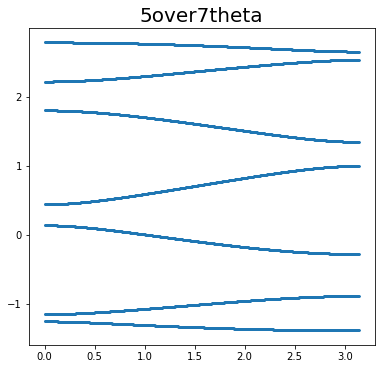

In [32]:
p = 5
q = 7
frac = fractions.Fraction(p, q)
mat = get_matrix_for_alpha(p, q)
plot_spectrum_lines(mat, f"5over7theta")

But it is known that we get $\min(g), \max(g)$ at $\theta=0$ and $\theta=\pi$ so we can calculate only them

In [33]:
def get_ranges(_mat):
    _mat_copy = _mat.copy()
    _q = _mat.shape[0]
    _mat_copy[0][_q-1] = _mat[0][_q-1] + 1
    _mat_copy[_q-1][0] = _mat[_q-1][0] + 1
    eig_zero = np.linalg.eigvalsh(_mat_copy)
    _mat_copy[0][_q-1] = _mat[0][_q-1] - 1
    _mat_copy[_q-1][0] = _mat[_q-1][0] - 1
    eig_pi = np.linalg.eigvalsh(_mat_copy)

    _ranges = []
    for eig0, eig1 in zip(eig_zero, eig_pi):
        if eig0 < eig1:
            _ranges.append((eig0, eig1))
        else:
            _ranges.append((eig1, eig0))

    return _ranges

In [34]:
mat = get_matrix_for_alpha(1, 2)
print_matrix(mat)
print(get_ranges(mat))
mat = get_matrix_for_alpha(5, 7)
print_matrix(mat)
print(get_ranges(mat))

 0  1
 1  1
[array([-1.56155281,  0.        ]), array([1.        , 2.56155281])]
 0  1  0  0  0  0  0
 1  1  1  0  0  0  0
 0  1  1  1  0  0  0
 0  0  1  0  1  0  0
 0  0  0  1  1  1  0
 0  0  0  0  1  1  1
 0  0  0  0  0  1  1
[array([-1.37720285, -1.2469796 ]), array([-1.14386443, -0.87938524]), array([-0.27389055,  0.14155805]), array([0.44504187, 1.        ]), array([1.34729636, 1.80193774]), array([2.21830965, 2.53208889]), array([2.65109341, 2.78399673])]


Now to plot the entire butterfly we'll just choose a list of fractions for each fraction $\alpha$
calculate the spectrum of $H_\alpha$ and plot it as lines at $y=\alpha$

For choosing the fractions we choose a list of denominators $q$ and for each we go over the fractions
$\frac{1}{q}$ to $\frac{q-1}{q}$.
We choose the denominators as the primes from $11$ to $n$ so we'll get unique fractions and
$2^33^3,5^3,7^2$ to get more of the simpler fractions such as $\frac{1}{2}, \frac{2}{3}, \frac{1}{6}$ etc...

In [8]:
def primesfrom2to(n):
    """ Input n>=6, Returns a array of primes, 2 <= p < n """
    sieve = numpy.ones(n//3 + (n%6==2), dtype=numpy.bool)
    for i in range(1,int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[       k*k//3     ::2*k] = False
            sieve[k*(k-2*(i&1)+4)//3::2*k] = False
    return numpy.r_[2,3,((3*numpy.nonzero(sieve)[0][1:]+1)|1)]

> **WARNING**: This is not super efficient so it might take some time

[ 11  13  17  19  23  29  31  37  41  43  47  53  59  61  67  71  73  79
  83  89  97 101 103 107 109 113 127 131 137 139 149 125  49 216]


KeyboardInterrupt: 

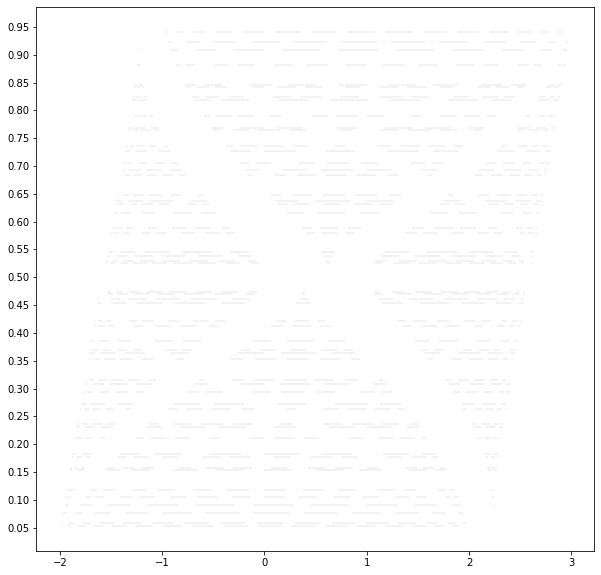

In [9]:
x = []
y = []
fig, ax = plt.subplots(figsize=(10,10))
ax.set_yticks(np.linspace(0, 1, 21))
n = 150
primes = primesfrom2to(n)[4:]
primes = np.append(primes, (125, 49, 216))
print(primes)
for q in primes:
    for p in range(1, q):
        frac = fractions.Fraction(p, q)
        mat = get_matrix_for_alpha(p, q)
        for x1, x2 in get_ranges(mat):
            ax.plot([x1, x2], [frac, frac], 'k-', linewidth=0.1)

fig.savefig(f'output/test_{n}_2.png', dpi=400)
# fig.savefig(f'output/test_{n}.svg', format='svg')
# fig.savefig(f'output/test_{n}.eps', format='eps')

### Plotting the butterfly with the Bloch theorem

In [ ]:
# den = 10000
# values_space = np.linspace(0,1, 10000)

In [ ]:
# fracs = [fractions.Fraction(i,den) for i in range(1, den)]
# crs = [continued_fraction(frac)[1:] for frac in fracs]
# zipped = list(zip(fracs, crs))
# # for frac, cr in zipped:
# #     print(f'{frac}: {cr}')

In [ ]:
# def calculate_trace(cr, E):
#     E = np.float(E)
#     x_prev = E
#     y_prev = 2
#     z_prev = E-1
#     for a in cr:
#         a = np.longlong(a)
#         S = scipy.special.eval_chebyu((a, a-1, a-2), (x_prev,))
#
#         x = np.multiply(z_prev, S[1])-np.multiply(y_prev, S[2])
#         y = x_prev
#         z = np.multiply(z_prev, S[0])-np.multiply(y_prev, S[1])
#         x_prev = x
#         y_prev = y
#         z_prev = z
#     return x

In [ ]:
# values_x = []
# values_y = []
# for E in values_space:
#     for frac, cr in zipped:
#         t = calculate_trace(cr, E)
#         if np.abs(t) < 2.1:
#             values_x.append(E)
#             values_y.append(frac)

In [ ]:
# print(f'{len(values_x)} out of {den * len(values_space)}, {len(values_x)/(den * len(values_space))}')

In [ ]:
# plt.scatter(values_x, values_y, 0.01)


In [ ]:
# count = 100000
# x = np.linspace(0, 1, count)
# y = np.zeros(count)
# cr = continued_fraction(fractions.Fraction(1, 2))[1:]
# print(cr)
# for i, E in enumerate(x):
#     t = calculate_trace(cr, E)
#     if np.abs(t) < 2.2:
#         y[i] = 1
#     else:
#         y[i] = 0
# plt.plot(x, y, 'o')
